# Delhi Air Quality Forecast

Delhi ranks among the top in the list of cities with the most polluted air. In this project I will make a model to forecast the hourly air quality index (PM2.5) for a year. The data used in this project is a subset of data from this kaggle dataset: https://www.kaggle.com/datasets/abhisheksjha/time-series-air-quality-data-of-india-2010-2023 . This dataset contains the historical hourly air quality data from 2010 to 2023. I am using only the files which start with 'DL'. I will use the last one year data to check forecasting accuracy and the data of the year before that for model validation and leftover data (~10 years) for training. To do this, I will use XGBoost regressor which is based on decision trees.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import os
%config InlineBackend.figure_format = 'retina'

## Data Cleaning
Our dataset contains hourly data from 40 stations in Delhi. But there are many missing data points in all the files. So we will use the average PM2.5 of all the stations as the air quality index of Delhi. This will provide us more data, which is also easier to clean.

In [2]:
path1 = '/Users/aneesh/Documents/Kaggle/Air quality India/Delhi_Air_Quality/archive/DL001.csv'
path2 = '/Users/aneesh/Documents/Kaggle/Air quality India/Delhi_Air_Quality/archive/DL009.csv'
data1 = pd.read_csv(path1)[['To Date', 'PM2.5 (ug/m3)']]
data2 = pd.read_csv(path2)[['To Date', 'PM2.5 (ug/m3)']]
data1['To Date'] = pd.to_datetime(data1['To Date'])
data2['To Date'] = pd.to_datetime(data2['To Date'])


### Example

Text(0, 0.5, 'PM2.5 (ug/m3)')

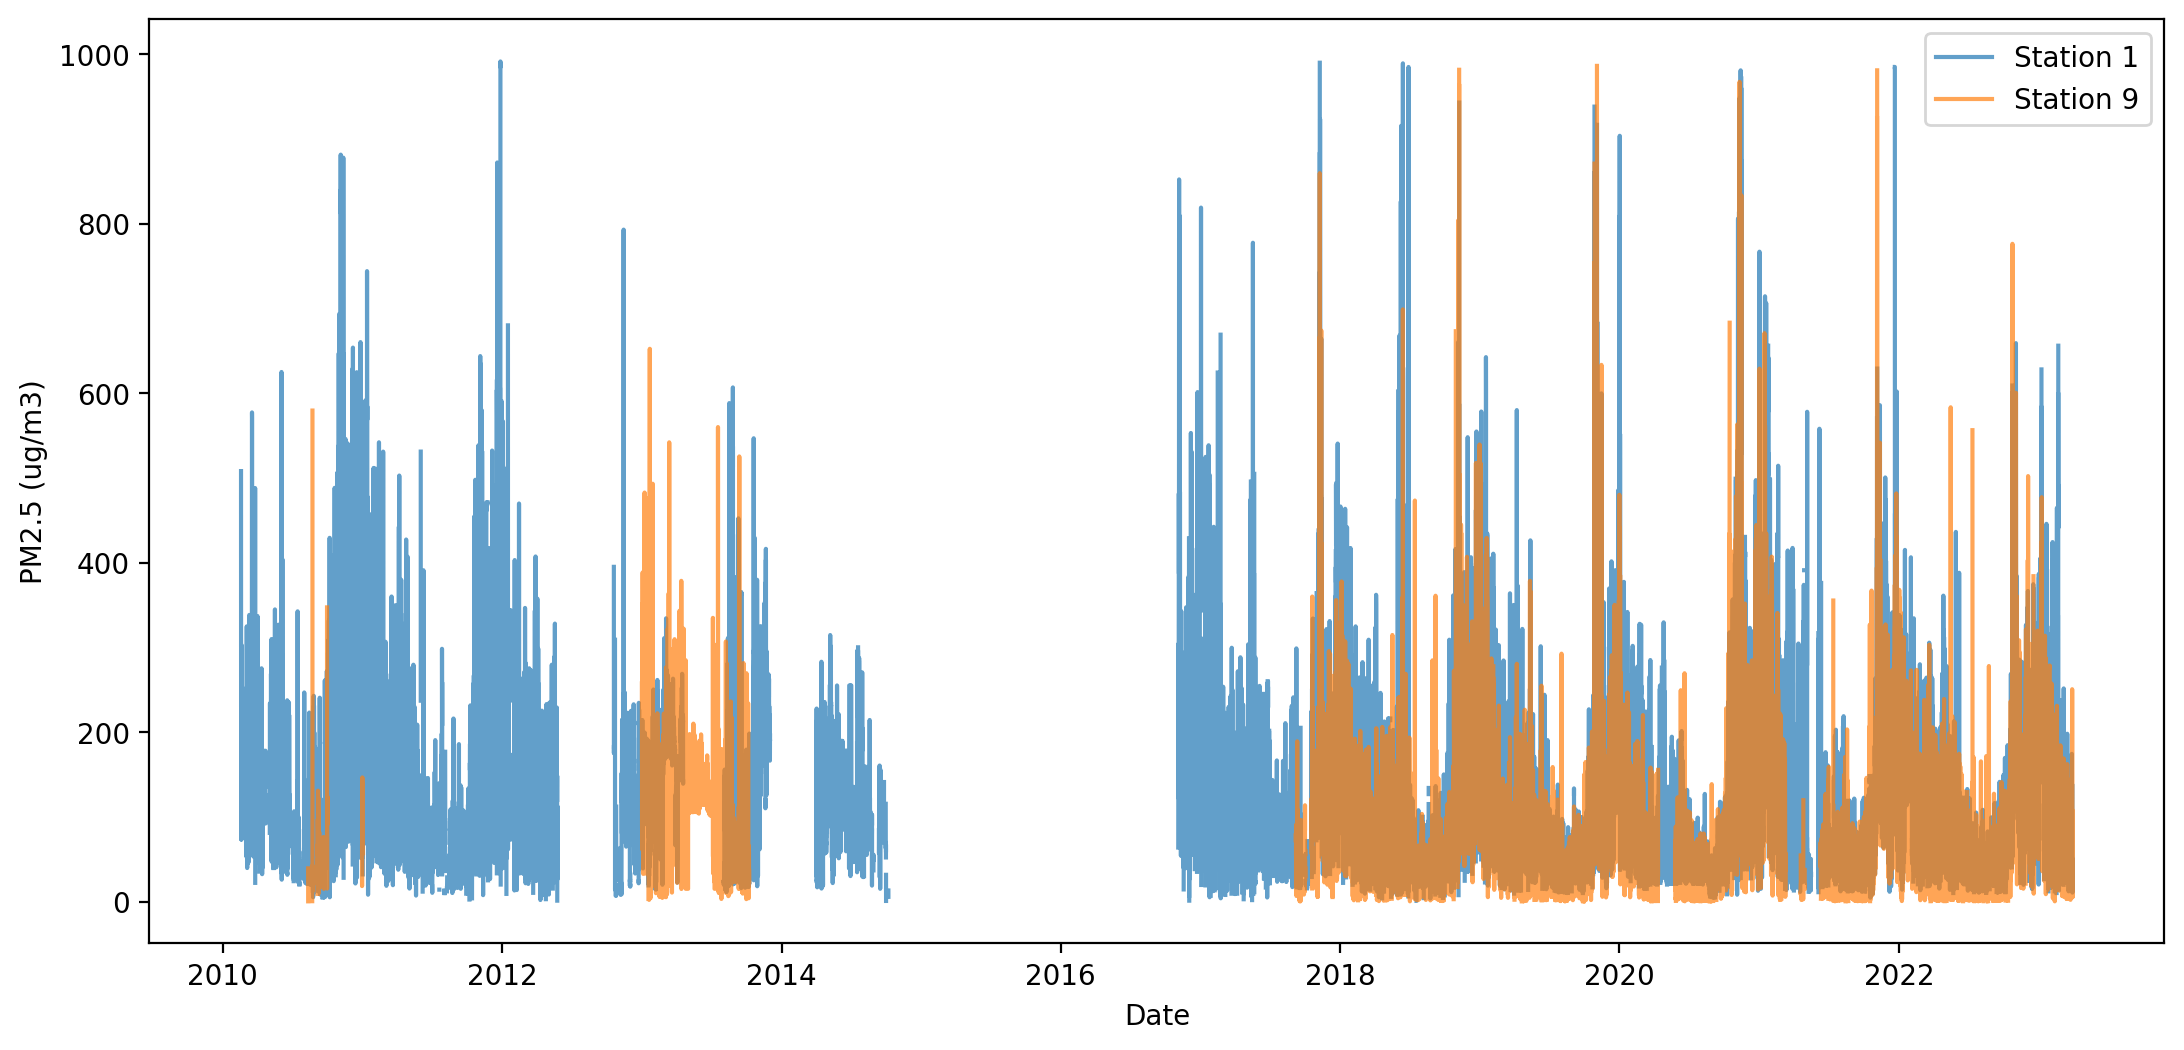

In [3]:
plt.figure(figsize=(13,6))
plt.plot(data1['To Date'], data1['PM2.5 (ug/m3)'],label='Station 1',alpha=0.7)
plt.plot(data2['To Date'], data2['PM2.5 (ug/m3)'],label='Station 9',alpha=0.7)
plt.legend()
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m3)')

As we can see there is lots of missing data. So we will take the average of all stations

Error reading file: /Users/aneesh/Documents/Kaggle/Air quality India/Delhi_Air_Quality/archive/DL018.csv


Text(0.5, 0, 'Date')

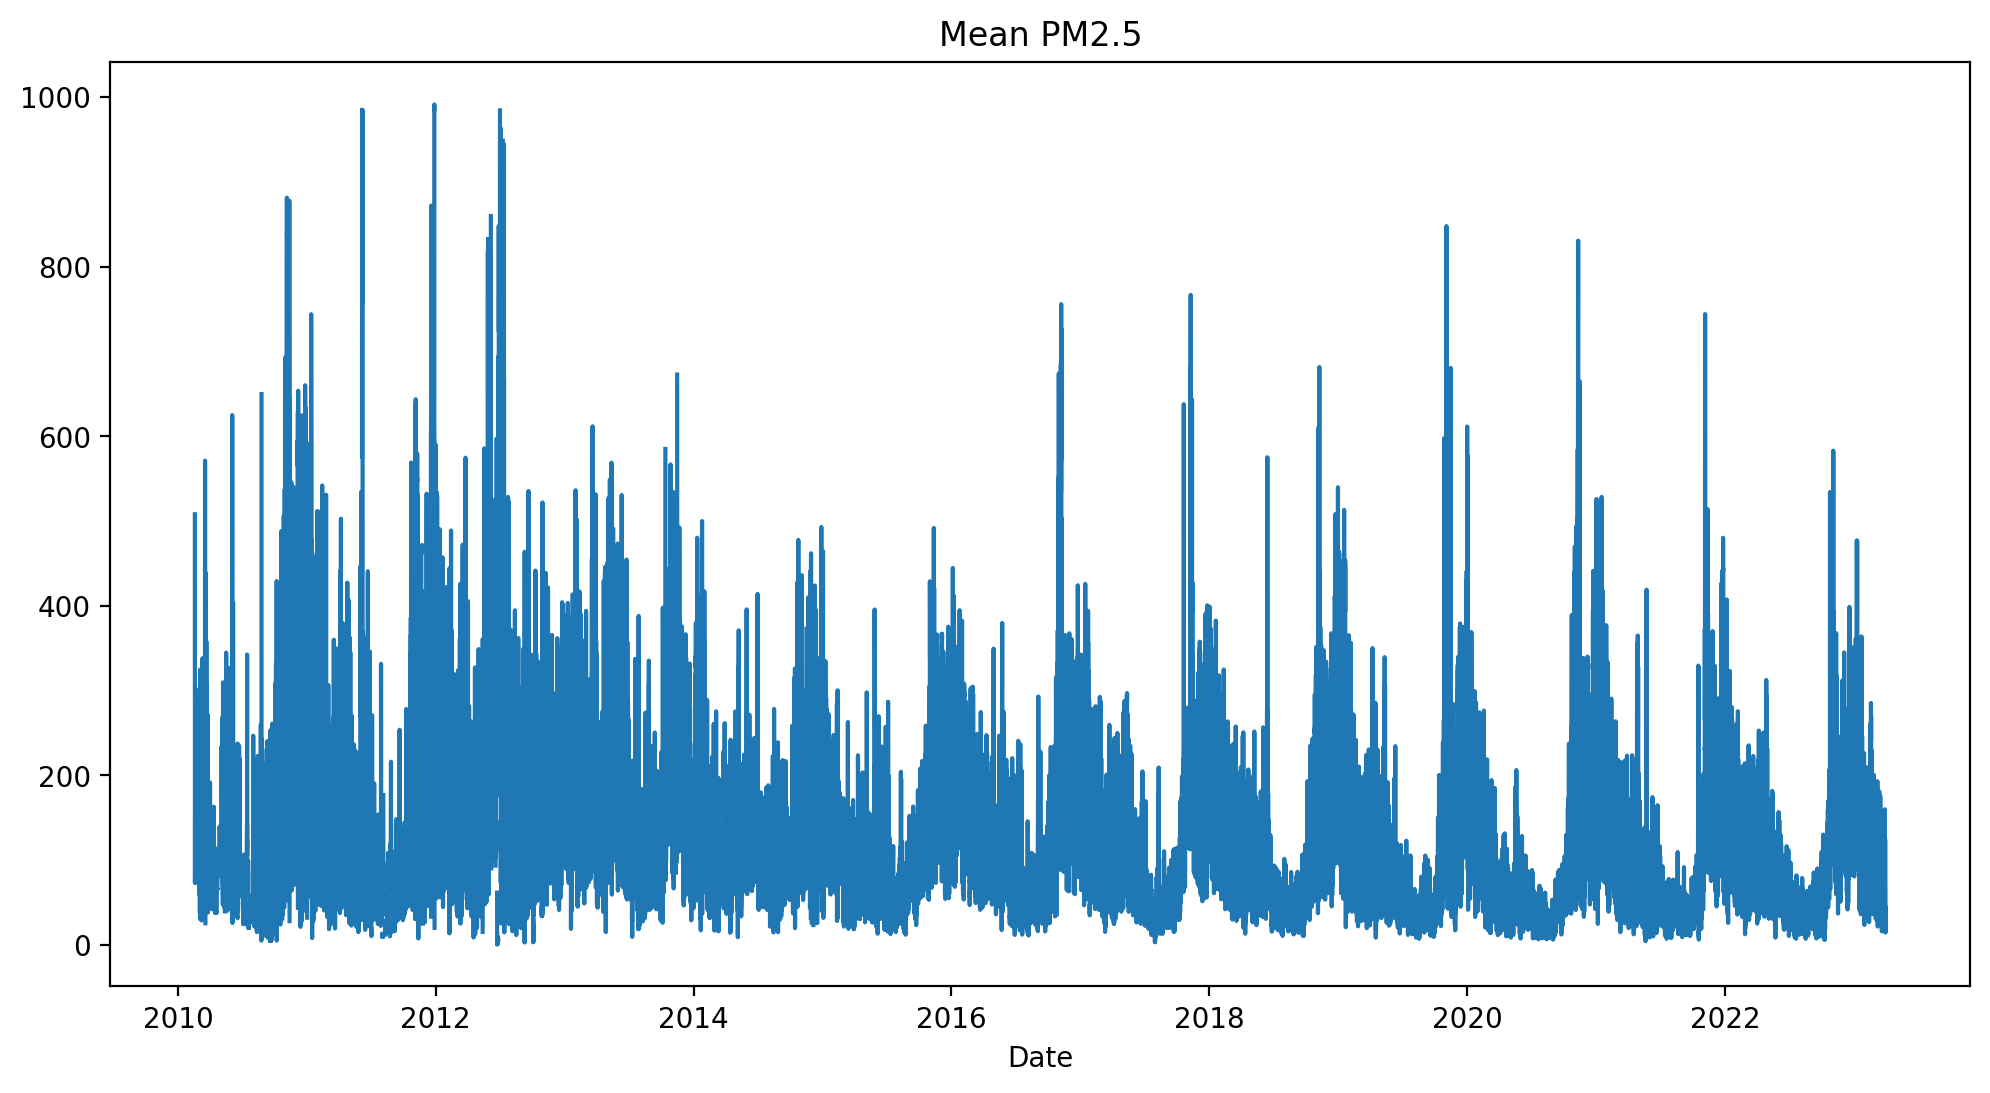

In [4]:
directory = '/Users/aneesh/Documents/Kaggle/Air quality India/Delhi_Air_Quality/archive/'  

combined_data = pd.DataFrame()
i = 0

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        if i == 0:
            combined_data = pd.read_csv(file_path)[['To Date','PM2.5 (ug/m3)']].copy()
        else:
            try:
                combined_data = pd.concat([combined_data, pd.read_csv(file_path)[['To Date','PM2.5 (ug/m3)']]])
            except:
                print("Error reading file:", file_path)
                pass
        i += 1

combined_data['To Date'] = pd.to_datetime(combined_data['To Date'])
mean_pm25_by_date = combined_data.groupby('To Date')['PM2.5 (ug/m3)'].mean()
final_data = mean_pm25_by_date.reset_index()
final_data.columns = ['To Date', 'Mean PM2.5']
plt.figure(figsize=(12, 6))
plt.plot(final_data['To Date'], final_data['Mean PM2.5'])
plt.title('Mean PM2.5')
plt.xlabel('Date')

Delete all the rows with NANs now

In [5]:
final_data.dropna(inplace=True)


In [6]:
final_data['To Date'] = pd.to_datetime(final_data['To Date'])
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112235 entries, 1140 to 116111
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   To Date     112235 non-null  datetime64[ns]
 1   Mean PM2.5  112235 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 MB


<Axes: xlabel='To Date'>

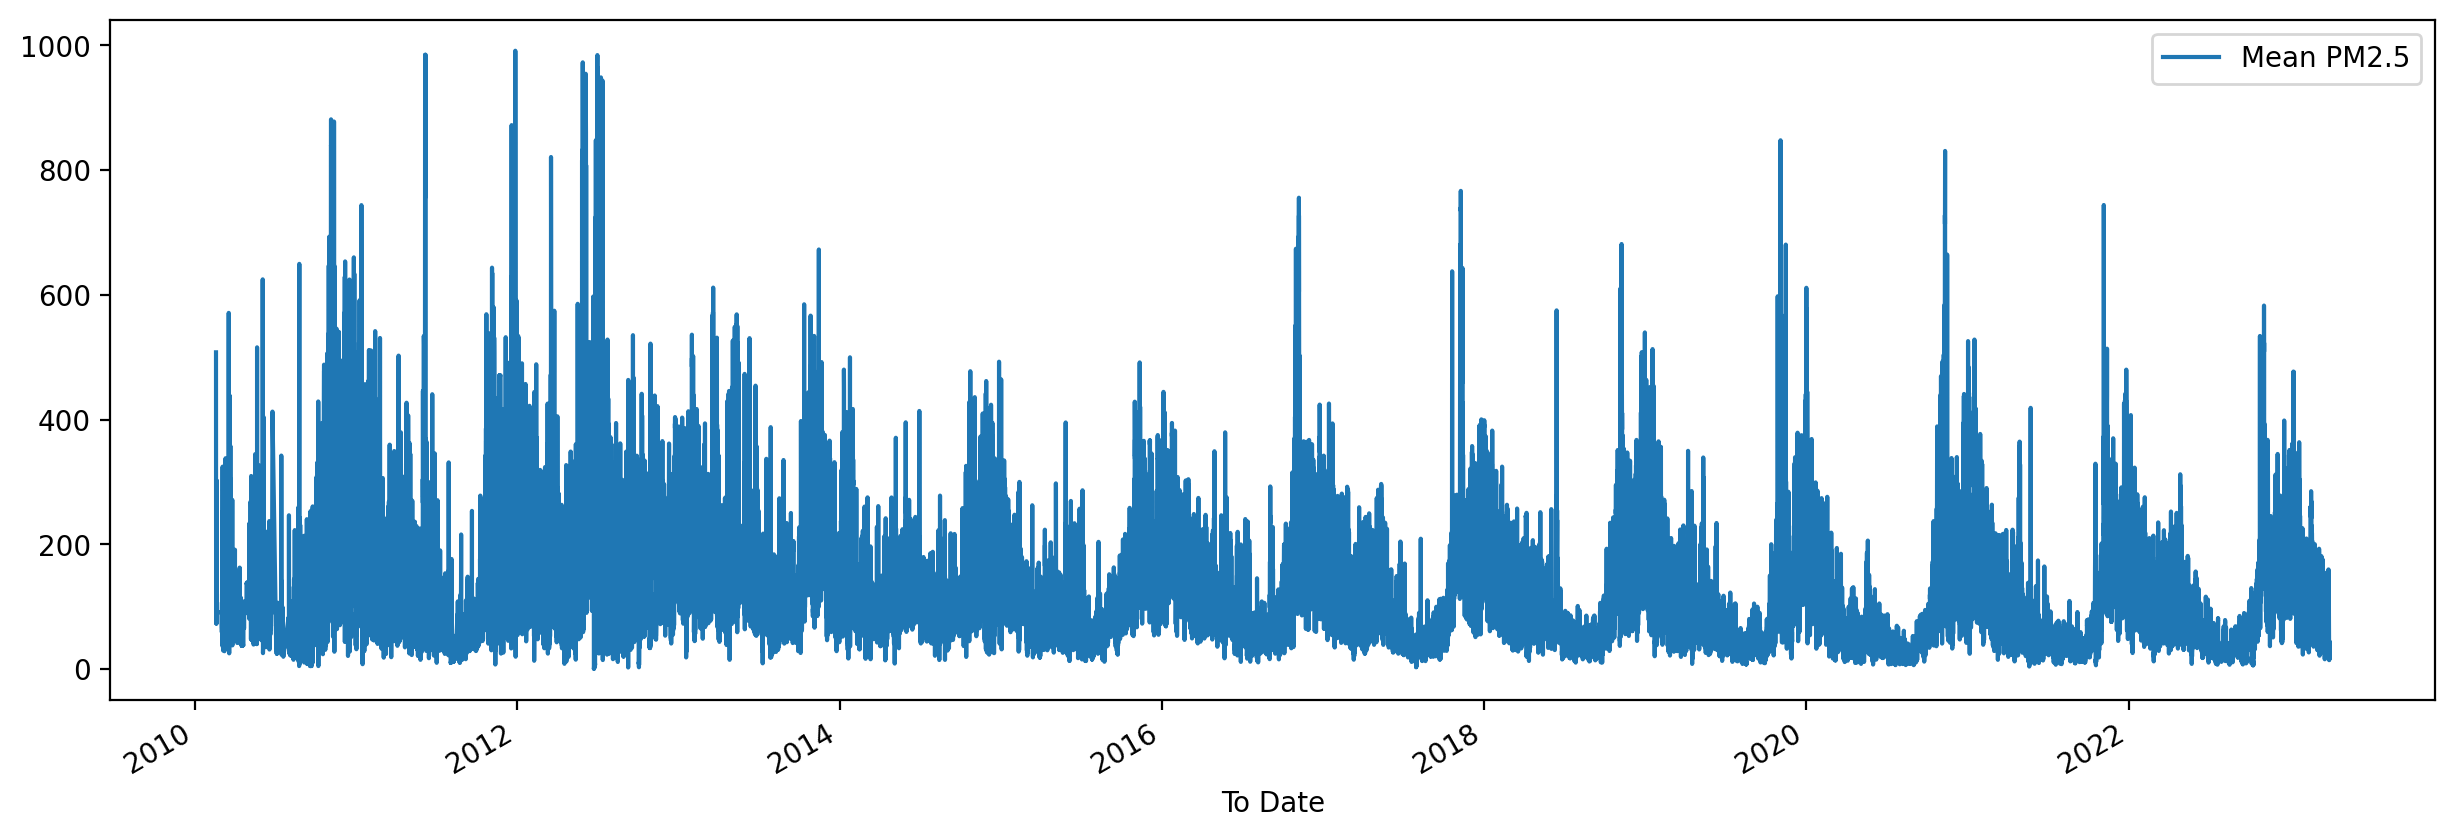

In [7]:
final_data.plot(x='To Date', y='Mean PM2.5', kind='line', figsize=(15, 5))

## Define the Features

We will use 6 featured from the timestamp: Hour, day of the week, day of the year, day of month, week of year and year. We will also add a 1 year lag data. This is ok because we're planning to forecast only upto a year. I have found that removing month and moving averages improve accuracy. After defining the lag feature, there will be some nan values in the initial one year data. Wel will delete those rows.

In [8]:
final_data['hour'] = final_data['To Date'].dt.hour
final_data['dayofweek'] = final_data['To Date'].dt.dayofweek
# final_data['month'] = final_data['To Date'].dt.month
final_data['year'] = final_data['To Date'].dt.year
final_data['dayofyear'] = final_data['To Date'].dt.dayofyear
final_data['dayofmonth'] = final_data['To Date'].dt.day
final_data['weekofyear'] = final_data['To Date'].dt.isocalendar().week.astype(int)
final_data['1yr lag'] = final_data['Mean PM2.5'].shift(365)
# final_data['2yr lag'] = final_data['Mean PM2.5'].shift(365*2)
# final_data['mnth avg 1yr lag'] = final_data['1yr lag'].rolling(window=30).mean()
final_data.dropna(inplace=True)

In [9]:
final_data['To Date'].max()

Timestamp('2023-04-01 00:00:00')

## Split the data into train, validation and test data

In [10]:
# split_date0 = pd.Timestamp('2010-01-01 00:00:00')
split_date1 = pd.Timestamp('2021-04-01 00:00:00')
split_date2 = pd.Timestamp('2022-04-01 00:00:00')
data_train = final_data.loc[(final_data['To Date'] <= split_date1)].copy()
data_val = final_data.loc[(final_data['To Date'] > split_date1) & (final_data['To Date'] < split_date2)].copy()
data_test = final_data.loc[final_data['To Date'] >= split_date2].copy()


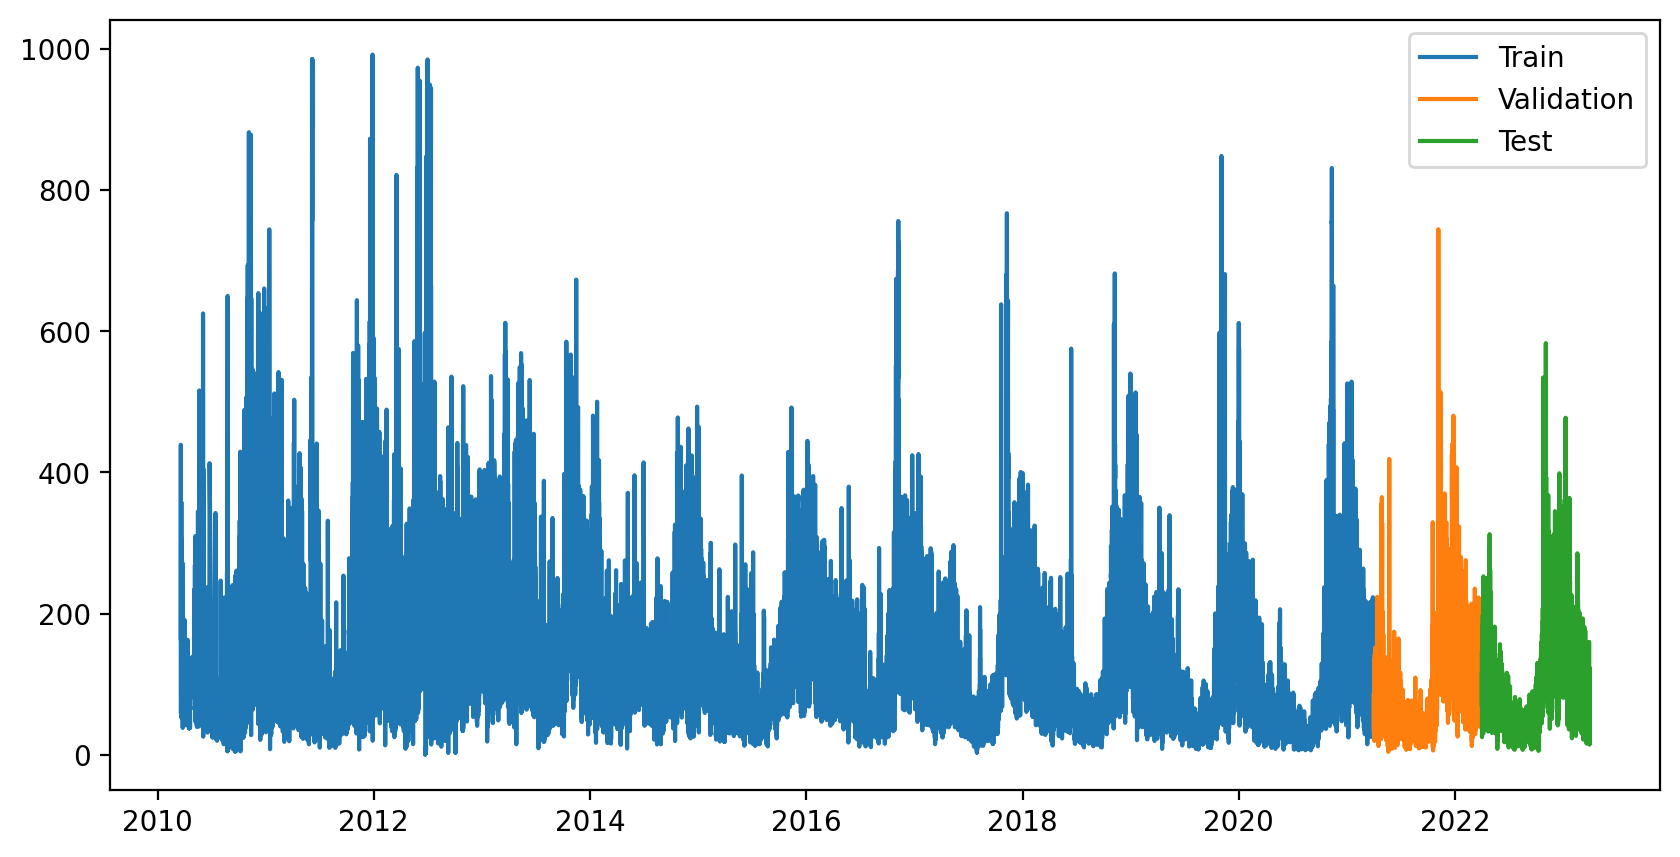

In [11]:
plt.figure(figsize=(10,5))
plt.plot(data_train['To Date'], data_train['Mean PM2.5'], label='Train')
plt.plot(data_val['To Date'], data_val['Mean PM2.5'], label='Validation')
plt.plot(data_test['To Date'], data_test['Mean PM2.5'], label='Test')
plt.legend(loc='best')

Define x and y values for each set

In [12]:
x_train = data_train.drop(['To Date'], axis=1).copy()
x_val = data_val.drop(['To Date'], axis=1).copy()
x_test = data_test.drop(['To Date'], axis=1).copy()
y_train = data_train['Mean PM2.5'].copy()
y_val = data_val['Mean PM2.5'].copy()
y_test = data_test['Mean PM2.5'].copy()
x_train.drop('Mean PM2.5', axis=1, inplace=True)
x_val.drop('Mean PM2.5', axis=1, inplace=True)
x_test.drop('Mean PM2.5', axis=1, inplace=True)

### Define the model
We will use a high n_estimators (we have lots of data) with early stopping to prevent overfitting. We will also use a low learning rate and use the squared error as the loss.

In [13]:
model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.005, random_state=1234, max_depth=5, objective='reg:squarederror')
model.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_val, y_val)],
        early_stopping_rounds=200)

[0]	validation_0-rmse:158.62371	validation_1-rmse:128.86960
[1]	validation_0-rmse:158.00224	validation_1-rmse:128.29397
[2]	validation_0-rmse:157.38446	validation_1-rmse:127.72302
[3]	validation_0-rmse:156.77044	validation_1-rmse:127.15548
[4]	validation_0-rmse:156.16023	validation_1-rmse:126.59389
[5]	validation_0-rmse:155.55366	validation_1-rmse:126.03364
[6]	validation_0-rmse:154.95087	validation_1-rmse:125.47886
[7]	validation_0-rmse:154.35168	validation_1-rmse:124.92543
[8]	validation_0-rmse:153.75622	validation_1-rmse:124.37740
[9]	validation_0-rmse:153.16433	validation_1-rmse:123.83073
[10]	validation_0-rmse:152.57607	validation_1-rmse:123.29055
[11]	validation_0-rmse:151.99249	validation_1-rmse:122.75196
[12]	validation_0-rmse:151.41194	validation_1-rmse:122.21356
[13]	validation_0-rmse:150.83550	validation_1-rmse:121.68351


/Users/aneesh/miniconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:150.26310	validation_1-rmse:121.15644
[15]	validation_0-rmse:149.69367	validation_1-rmse:120.63121
[16]	validation_0-rmse:149.12731	validation_1-rmse:120.10527
[17]	validation_0-rmse:148.56381	validation_1-rmse:119.58619
[18]	validation_0-rmse:148.00435	validation_1-rmse:119.07115
[19]	validation_0-rmse:147.44887	validation_1-rmse:118.55924
[20]	validation_0-rmse:146.89630	validation_1-rmse:118.05139
[21]	validation_0-rmse:146.34664	validation_1-rmse:117.54484
[22]	validation_0-rmse:145.80094	validation_1-rmse:117.04253
[23]	validation_0-rmse:145.25875	validation_1-rmse:116.54451
[24]	validation_0-rmse:144.71928	validation_1-rmse:116.05548
[25]	validation_0-rmse:144.18381	validation_1-rmse:115.56369
[26]	validation_0-rmse:143.65058	validation_1-rmse:115.07883
[27]	validation_0-rmse:143.12112	validation_1-rmse:114.59905
[28]	validation_0-rmse:142.59496	validation_1-rmse:114.12253
[29]	validation_0-rmse:142.07262	validation_1-rmse:113.64297
[30]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1234, ...)

### Check Feature importance.

Remove features with very low importance. This will improve the model. Day of the year and year seems to be the most important features.

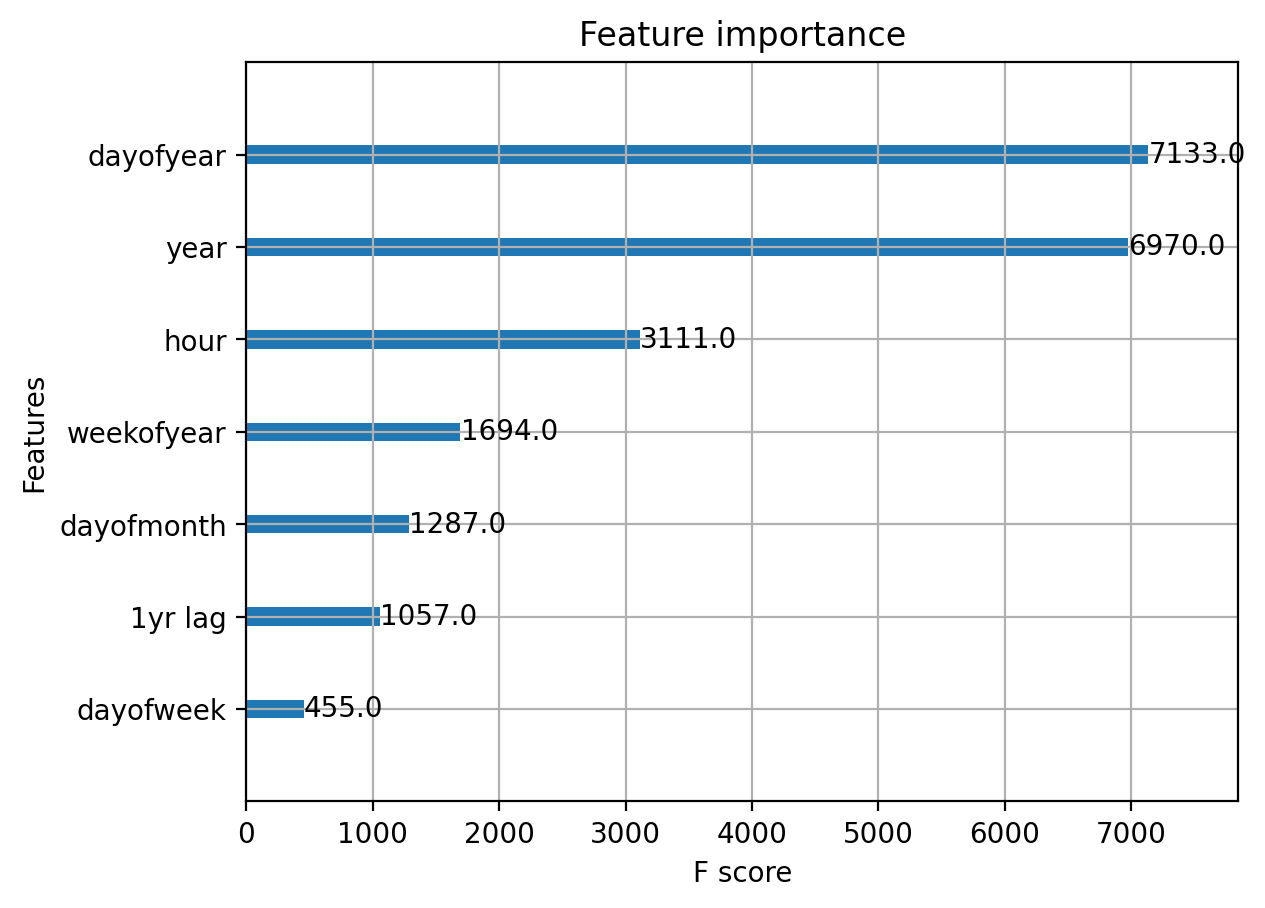

In [14]:
# Plot feature importance
xgb.plot_importance(model)
plt.show()


### Compare the model predictions against the actual data

We can see that in both the validation and test datasets, the predictions are very closely following the actual data.

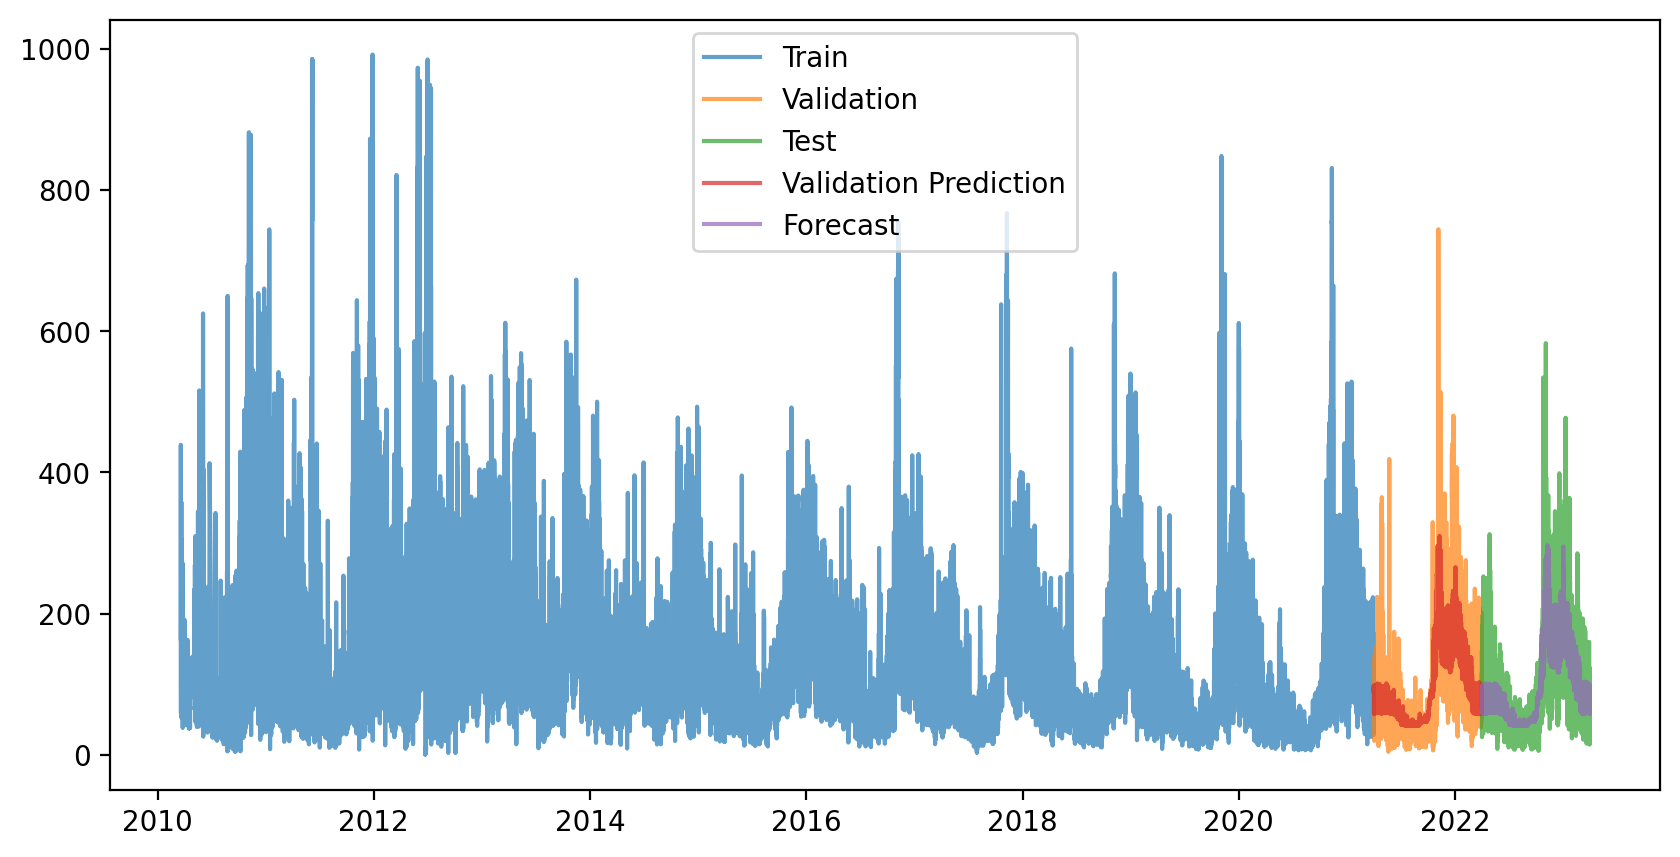

In [15]:
prediction_test = model.predict(x_test)
prediction_val = model.predict(x_val)
plt.figure(figsize=(10,5))
plt.plot(data_train['To Date'], data_train['Mean PM2.5'], label='Train',alpha=0.7)
plt.plot(data_val['To Date'], data_val['Mean PM2.5'], label='Validation',alpha=0.7)
plt.plot(data_test['To Date'], data_test['Mean PM2.5'], label='Test',alpha=0.7)
plt.plot(data_val['To Date'], prediction_val, label='Validation Prediction',alpha=0.7)
plt.plot(data_test['To Date'], prediction_test, label='Forecast',alpha=0.7)
plt.legend(loc='best')

### Zoom into the forecast vs actual data comparison

Our model is predicting the air quality variation pretty accurately

Text(0, 0.5, 'PM2.5')

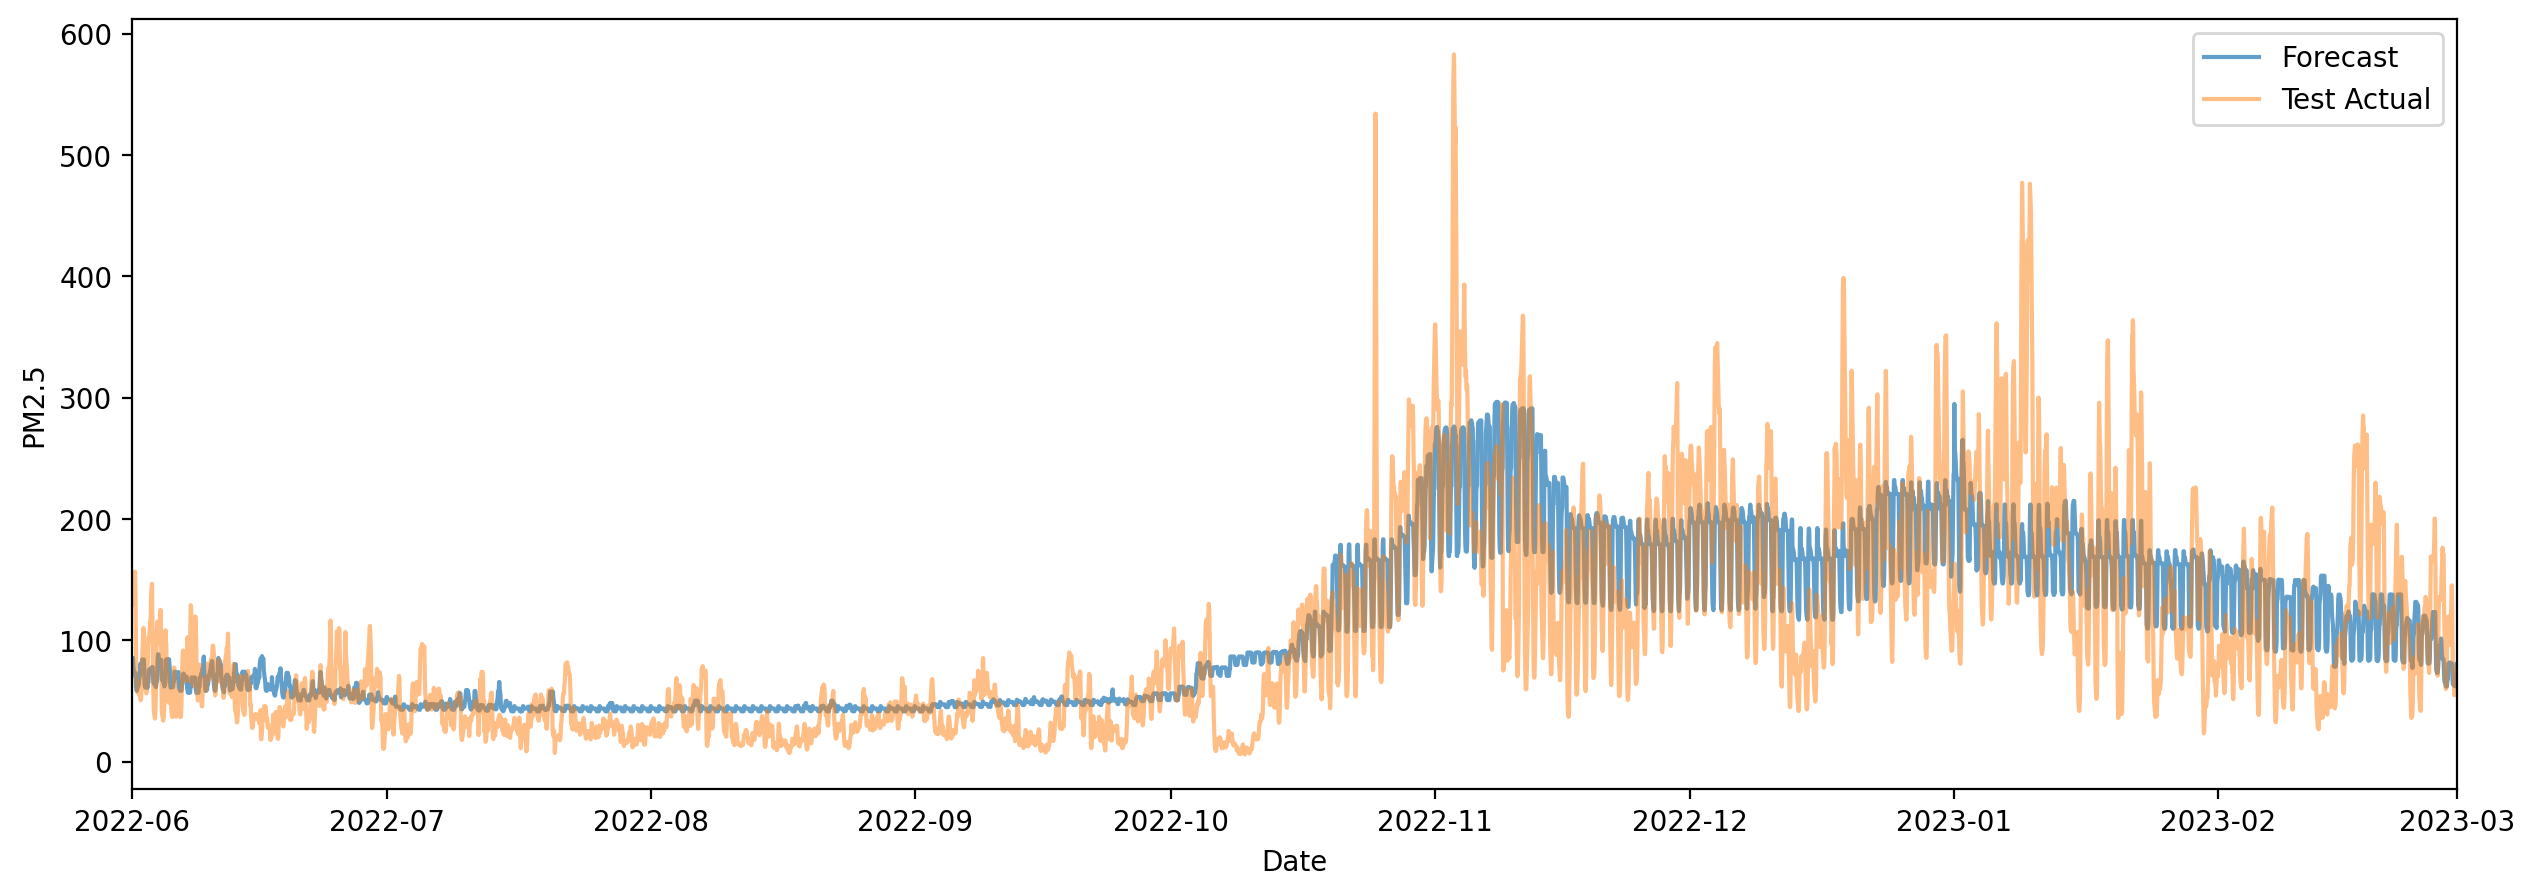

In [16]:
plt.figure(figsize=(15,5))
plt.plot(data_test['To Date'], prediction_test, label='Forecast',alpha=0.7)
plt.plot(data_test['To Date'], y_test, label='Test Actual',alpha=0.5)
plt.xlim(pd.Timestamp('2022-06-01 00:00:00'), pd.Timestamp('2023-03-01 00:00:00'))
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('PM2.5')

## Finally check the accuracy

In [17]:
mean_abs_error_val = mean_absolute_error(y_val, prediction_val)
mean_abs_error_test = mean_absolute_error(y_test, prediction_test)

print("Mean Absolute Error (Validation):", mean_abs_error_val)
print("Mean Absolute Error (Test):", mean_abs_error_test)


Mean Absolute Error (Validation): 37.044227398410435
Mean Absolute Error (Test): 34.247491145147485


### Our model forecasts one year air quality data with 66% accuracy